<a href="https://colab.research.google.com/github/atiqurx/car-image-classification/blob/main/car_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get the Dataset

The dataset used for in this notebook is 1.81G. Instead of downloadint the data to local and uploading, the dataset will directly downloaded from Kaggle to Google colab for usage. The Kaggle Api token is required for this.

In [50]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/

In [51]:
!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder

stanford-car-dataset-by-classes-folder.zip: Skipping, found more recently modified local copy (use --force to force download)


In [52]:
import zipfile
zip_ref = zipfile.ZipFile("/content/stanford-car-dataset-by-classes-folder.zip", 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [53]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import time
import os
import PIL.Image as Image
from IPython.display import display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Dataset Description

The Stanford Cars dataset consists of 196 classes of cars with a total of 16,185 images. The data is divided into almost a 50-50 train/test split with 8,144 training images and 8,041 testing images. Categories are typically at the level of Make, Model, Year. The images are 360×240.

## Load Data and Transform

After loading the dataset, the images are resized to 300x300 px with random horizontal flip, random rotation and normalization.

In [54]:
dataset_dir = "/content/car_data/car_data/"

train_tfms = transforms.Compose([transforms.Resize((300, 300)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(10),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tfms = transforms.Compose([transforms.Resize((300, 300)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.ImageFolder(root=dataset_dir+"train", transform = train_tfms)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle=True, num_workers = 2)

dataset2 = torchvision.datasets.ImageFolder(root=dataset_dir+"test", transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size = 32, shuffle=False, num_workers = 2)

## Training and Evaluating a PyTorch Model

This function trains a PyTorch model using a specified criterion, optimizer, and learning rate scheduler. It iterates over a specified number of epochs, calculating and printing the training loss and accuracy for each epoch. After each epoch, it evaluates the model on a test dataset and records the test accuracy. The function returns the trained model along with lists of training losses, training accuracies, and test accuracies over the epochs.

In [55]:
def train_model(model, criterion, optimizer, scheduler, n_epochs=5):

    losses = []
    accuracies = []
    test_accuracies = []

    # Set the model to train mode
    model.train()

    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0

        for i, data in enumerate(trainloader, 0):
            # Get the inputs and move them to the specified device
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            # Forward pass, backward pass, and optimization
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate loss and accuracy
            running_loss += loss.item()
            running_correct += (labels == predicted).sum().item()

        epoch_duration = time.time() - since
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 * running_correct / (32 * len(trainloader))
        print(f"Epoch {epoch + 1}, duration: {epoch_duration:.2f}s, loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f}")

        losses.append(epoch_loss)
        accuracies.append(epoch_acc)

        # Evaluate model on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)

        # Set model back to train mode
        model.train()

        # Adjust learning rate based on validation accuracy
        scheduler.step(test_acc)

    print('Finished Training')
    return model, losses, accuracies, test_accuracies


## Evaluate on Train Data

This code defines a function eval_model to evaluate a given model on the test dataset. It calculates the accuracy of the model on the test images and prints the result. The function is called during the training process to monitor the model's performance on unseen data.

In [56]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %.2f %%' % test_acc)
    return test_acc


## Model Initialization

This code block initializes a pre-trained ResNet-34 model for transfer learning on the car dataset. It replaces the last fully connected layer of the ResNet-34 model with a new untrained layer that has 196 output features, corresponding to the number of classes in the dataset. The model is then moved to the specified device (GPU if available).

In [57]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 196)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

## Train Model

This code block trains the initialized model (model_ft) using the specified criterion, optimizer, and learning rate scheduler over 5 epochs. It tracks and stores the training losses and accuracies for each epoch, as well as the test accuracy after each epoch.

Takes more time to train which high n_epochs.

In [58]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=10)

Epoch 1, duration: 96.74s, loss: 3.7733, acc: 18.2475
Accuracy of the network on the test images: 33.57 %
Epoch 2, duration: 95.67s, loss: 1.5318, acc: 58.6029
Accuracy of the network on the test images: 51.24 %
Epoch 3, duration: 95.74s, loss: 0.8847, acc: 75.3676
Accuracy of the network on the test images: 68.23 %
Epoch 4, duration: 94.31s, loss: 0.5684, acc: 83.3088
Accuracy of the network on the test images: 73.72 %
Epoch 5, duration: 92.60s, loss: 0.3836, acc: 89.0931
Accuracy of the network on the test images: 71.50 %
Epoch 6, duration: 94.41s, loss: 0.2604, acc: 92.1569
Accuracy of the network on the test images: 75.25 %
Epoch 7, duration: 93.67s, loss: 0.1860, acc: 94.7549
Accuracy of the network on the test images: 81.89 %
Epoch 8, duration: 94.88s, loss: 0.0819, acc: 97.9412
Accuracy of the network on the test images: 88.26 %
Epoch 9, duration: 92.77s, loss: 0.0513, acc: 98.7990
Accuracy of the network on the test images: 88.65 %
Epoch 10, duration: 93.24s, loss: 0.0433, acc:

In [59]:
# Find class indices and map them to their names

def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(dataset_dir+"train")

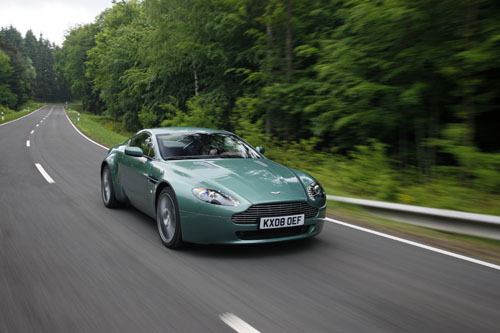

Predicted class: Aston Martin V8 Vantage Coupe 2012


In [60]:
def test_model_on_image(model, image_path, classes):
    # Switch the model to evaluation mode
    model.eval()

    # Define the transform for the input image
    loader = transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load and preprocess the image
    image = Image.open(image_path)
    image = loader(image).float()
    image = torch.autograd.Variable(image, requires_grad=True)
    image = image.unsqueeze(0)
    image = image.cuda() if torch.cuda.is_available() else image

    # Perform the prediction
    output = model(image)
    _, predicted = torch.max(output.data, 1)

    # Display the image and prediction
    display(Image.open(image_path))
    print("Predicted class:", classes[predicted.item()])

image_path = dataset_dir + "/test/Aston Martin V8 Vantage Coupe 2012/02815.jpg"
test_model_on_image(model_ft, image_path, classes)


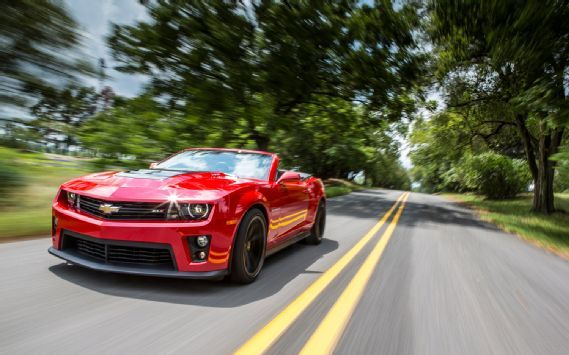

Predicted class: Chevrolet Camaro Convertible 2012


In [61]:
image_path = dataset_dir + "/test/Chevrolet Camaro Convertible 2012/01726.jpg"
test_model_on_image(model_ft, image_path, classes)

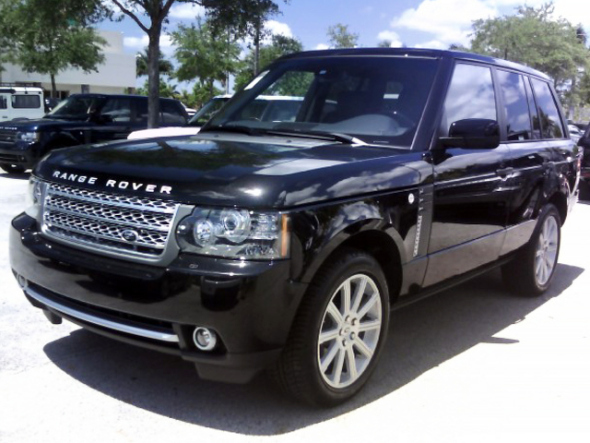

Predicted class: Land Rover LR2 SUV 2012


In [62]:
image_path = dataset_dir + "/test/Land Rover Range Rover SUV 2012/00358.jpg"
test_model_on_image(model_ft, image_path, classes)